## https://slundberg.github.io/shap/notebooks/Census+income+classification+with+XGBoost.html
## https://slundberg.github.io/shap/notebooks/Census+income+classification+with+XGBoost.html#Load-dataset

## https://brunch.co.kr/@snobberys/137
##  https://arxiv.org/pdf/1802.03888.pdf


*  러신머닝 모들에서 부정확하다는 것에 대한 위험에 대한 이야기를 한다. 
* 만약 너가 gradient boosting machine 이나 random foreset 에 대한 정확도 뿐만 아니라 해석을 하는 것도 굉장히 중요할 것이다.
* 은행에서 한 사람에 대한 재정 상태 예측에 대한 것을 예로 들어보자
* 우리 모델이 더 정확할수록 은행은 더 돈을 볼 수 있게되고 떄문에 이러한 예측은 대출신청에서 사용될 수 있다.
* 우린는 또한 이러한 예측이 왜 필요한지 법적으로 확인 할 수 있다.
* 몇몇 모델에 실험을 하였을 때  **XGBoost gradient booseted trees**가 좋은 정확도를 가진다.
* 하지만 그 모델은 왜 좋은지를 설명하기가 어렵다. 그래서 우리는 선형모델로이나 우리의 xgboost 모델을 해석할 수 있는 방향으로 노력할 것이다.

In [1]:
from sklearn.model_selection import train_test_split
import xgboost
!pip install shap
import shap
import numpy as np
import matplotlib.pylab as pl



    100% |████████████████████████████████| 225kB 5.3MB/s 
    100% |████████████████████████████████| 51kB 10.2MB/s 
  Running setup.py bdist_wheel for shap ... - \ | / done
  Stored in directory: /content/.cache/pip/wheels/97/44/46/a211df64623ce2906ce27e89d6ce4c86b6a7b374663a5b8840
  Running setup.py bdist_wheel for iml ... - \ done
  Stored in directory: /content/.cache/pip/wheels/9c/07/52/53ad784db16f282fda909719afc206b833db3121fbb0f1f176
Successfully built shap iml


## 데이터 불러들이기


In [2]:
# print the JS visualization code to the notebook
shap.initjs()
X, y = shap.datasets.adult()
X_display , y_display = shap.datasets.adult(display=True)
print(X_display.shape)
# 분리
X_train, X_test , y_train, y_test = train_test_split(X,y , test_size= 0.2, random_state= 7)
d_train = xgboost.DMatrix(X_train , label=y_train,)
d_test = xgboost.DMatrix(X_test , label=y_test)


(32561, 12)


## Train the model

In [3]:
params ={ 
  "eta" : 0.01 ,
  "objective" : "binary:logistic" ,
  "subsample" : 0.5 ,
  "base_scroe" : np.mean(y_train) ,
  "eval_metric" : "logloss"
}

model = xgboost.train(params, d_train, 5000, evals = [(d_test, "test")] , verbose_eval =100 , early_stopping_rounds=20
                     
                     )

[0]	test-logloss:0.68734
Will train until test-logloss hasn't improved in 20 rounds.
[100]	test-logloss:0.405519
[200]	test-logloss:0.331496
[300]	test-logloss:0.305818
[400]	test-logloss:0.294625
[500]	test-logloss:0.288705
[600]	test-logloss:0.284894
[700]	test-logloss:0.282666
[800]	test-logloss:0.281252
[900]	test-logloss:0.280184
[1000]	test-logloss:0.279574
Stopping. Best iteration:
[1028]	test-logloss:0.279307



In [6]:
model.feature_names

['Age',
 'Workclass',
 'Education-Num',
 'Marital Status',
 'Occupation',
 'Relationship',
 'Race',
 'Sex',
 'Capital Gain',
 'Capital Loss',
 'Hours per week',
 'Country']

## classic feature attibutions


global featrue importance xgboost에서 제시한 계산을 시도 했다.

shap 의 사용 값에 대한 그들은 서로 모순이 된다.  때문에 그들은 일관성을 보장한다.

* Weight.  The number of times a feature is used to split the data across all trees.
* Cover.  The number of times a feature is used to split the data across all trees weighted by the number of training data points that go through those splits.
* Gain.  The average training loss reduction gained when using a feature for splitting.

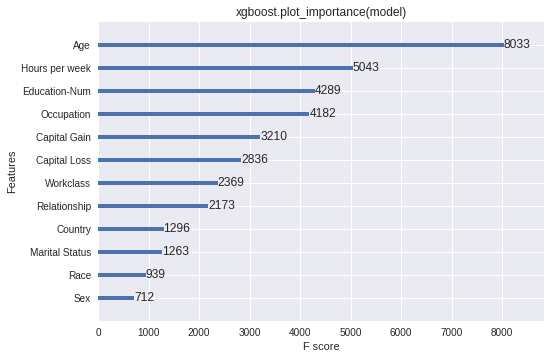

In [7]:
xgboost.plot_importance(model)
pl.title("xgboost.plot_importance(model)")
pl.show()

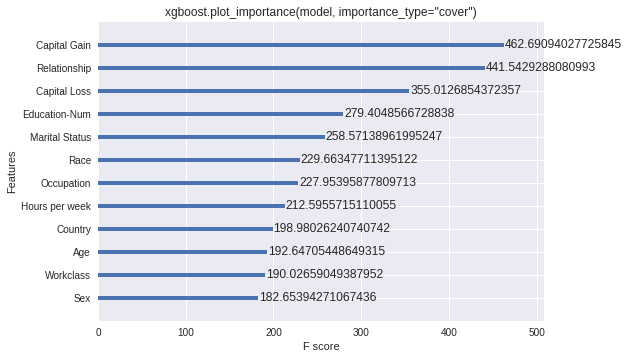

In [9]:
xgboost.plot_importance(model, importance_type="cover")
pl.title('xgboost.plot_importance(model, importance_type="cover")')
pl.show()

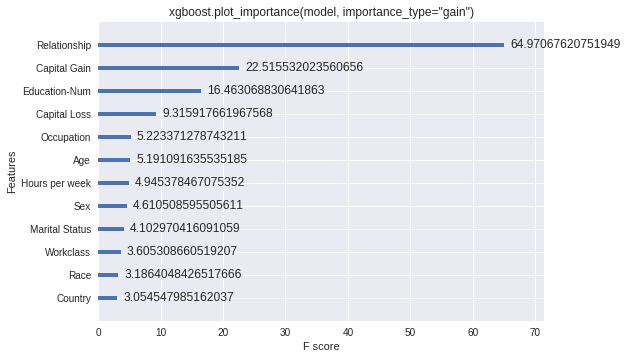

In [10]:
xgboost.plot_importance(model , importance_type="gain")
pl.title('xgboost.plot_importance(model, importance_type="gain")')
pl.show()

## Explain predictions

Tree SHAP 시행을 할 것이다.





#### What makes a measure of feature importance good or bad?

* **Consistency**. Whenever we change a model such that it relies more on a feature, then the attributed importance for that feature should not decrease.
* **Accuracy.** The sum of all the feature importances should sum up to the total importance of the model. (For example if importance is measured by the R² value then the attribution to each feature should sum to the R² of the full model)

* If **consistency** fails to hold, then we can’t compare the attributed feature importances between any two models, because then having a higher assigned attribution doesn’t mean the model actually relies more on that feature.

* If **accuracy** fails to hold then we don’t know how the attributions of each feature combine to represent the output of the whole model. We can’t just normalize the attributions after the method is done since this might break the consistency of the method.

In [0]:
##  1000 트리에 대한 30개 샘플로 설명하기 때문에 1분이나 2분정도 걸린다.
shap_values = shap.TreeExplainer(model).shap_values(X)

## Visualize a single prediction

display values 데이터 프레임을 사용할 것이다. 그래서 우리는 항목별 코드 대신에 한 줄로 얻을 수 있다.


In [32]:
shap.initjs()
shap.force_plot(shap_values[0, :], X_display.iloc[0,:] )

In [33]:
print(shap_values[0, :])
print(X_display.iloc[0,:])

[ 0.21102397 -0.22391406  0.5854105  -0.25008637 -0.35339123 -1.1290427
  0.01289498  0.20461701 -1.1257331  -0.05184652 -0.24322791  0.01289279
 -1.3660002 ]
Age                           39
Workclass              State-gov
Education-Num                 13
Marital Status     Never-married
Occupation          Adm-clerical
Relationship       Not-in-family
Race                       White
Sex                         Male
Capital Gain                2174
Capital Loss                   0
Hours per week                40
Country            United-States
Name: 0, dtype: object


## visualize many predictions

shap.fore_plot(shap_values[:1 000, :] , X_display)

In [35]:
shap.initjs()
shap.force_plot(shap_values[:1000,:], X_display.iloc[:1000,:])

## Bar chart of mean importance

이것은 데이터 집합 전체의 SHAP 값 크기의 평균을 취해 간단한 막대 차트로 그립니다.

[11  6  1  7  9  3  4 10  8  2  0  5]
[ 0  1  2  3  4  5  6  7  8  9 10 11] 12


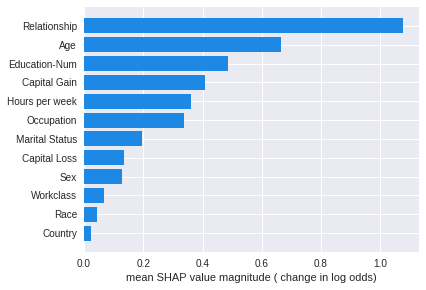

In [42]:
global_shap_vals = np.abs(shap_values).mean(0)[:-1]
inds = np.argsort(global_shap_vals)
print(inds)
y_pos = np.arange(X.shape[1])
print(y_pos,X.shape[1])

pl.barh(y_pos , global_shap_vals[inds], color="#1E88E5")
pl.yticks(y_pos , X.columns[inds])
pl.gca().spines["right"].set_visible(False)
pl.gca().spines["top"].set_visible(False)
pl.xlabel("mean SHAP value magnitude ( change in log odds)")
pl.gcf().set_size_inches(6, 4.5)
pl.show()

## SHAP Summary Plot
* 전형적인 feature importance bar chart 보다 SHAP 의 SCATTER PLOT을 이용하여 각각의 특징을 더 많이 효과적으로 보여줄 수 있게 되었다.
* the relationship feature has more total model impact than the captial gain feature
* those samples where capital gain matters it has more impact than age
* capital gain effects a few predictions by a large amount, while age effects all predictions by a smaller amount.
* Scatter point가 선에 잘 적합하지 않을 때 , 

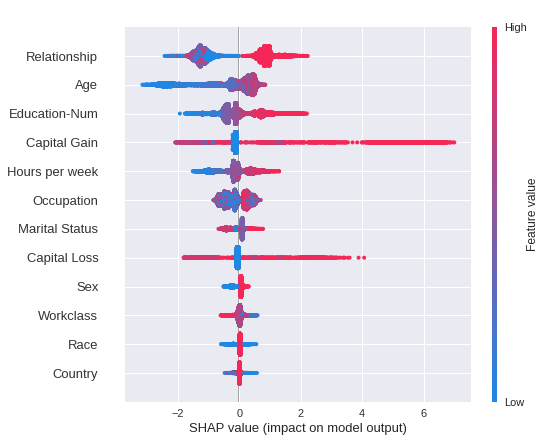

In [43]:
shap.summary_plot(shap_values, X)

## SHAP Dependence Plots
 * Shap depence plot들은 전체 데이터 셋을 통해서 한개의 특징을 효과를 보여줄 수 있다.
 * They plot a feature's value vs. the SHAP value of that feature across many samples.
 * SHAP dependence plots are similar to partial dependence plots, but account for the interaction effects present in the features, and are only defined in regions of the input space supported by data.
 * The vertical dispersion of SHAP values at a single feature value is driven by interaction effects
 * another feature is chosen for coloring to highlight possible interactions.

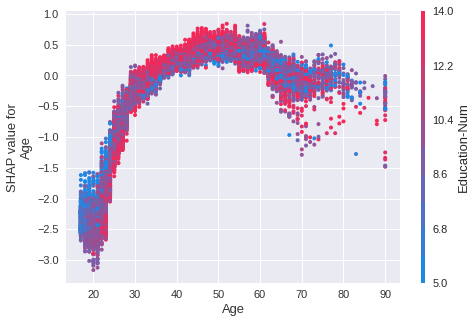

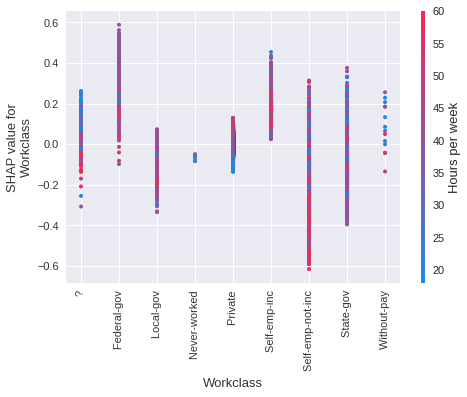

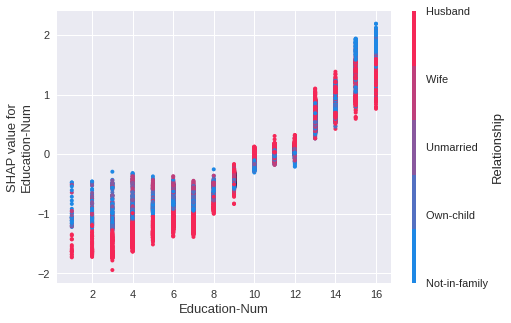

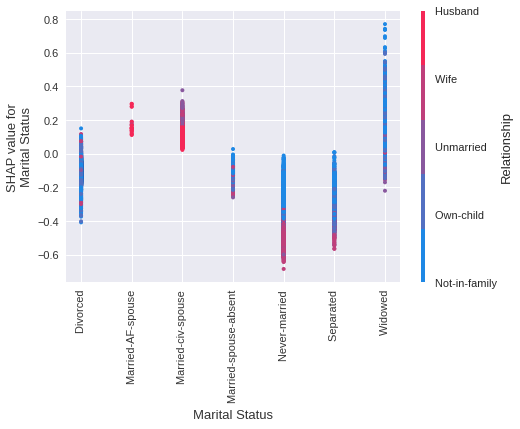

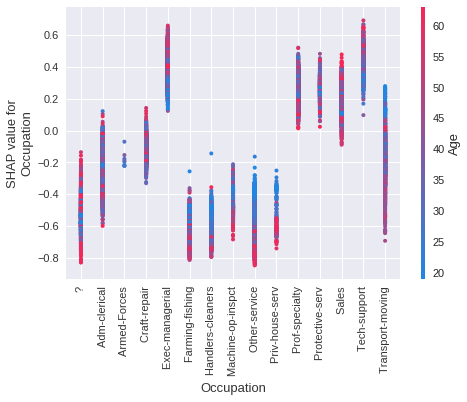

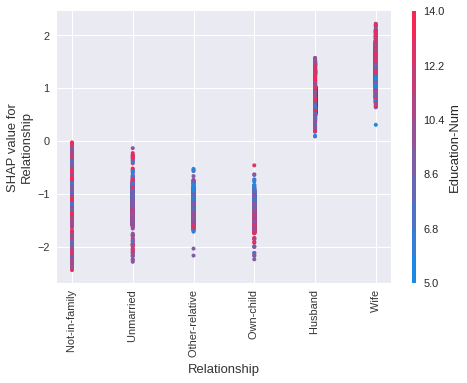

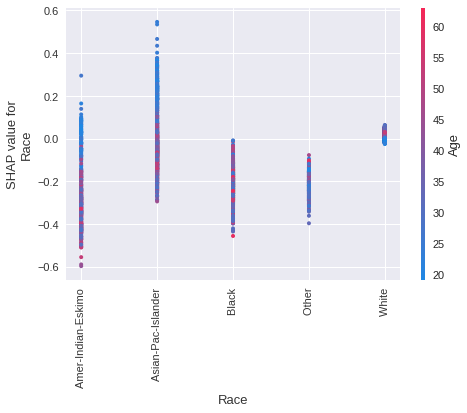

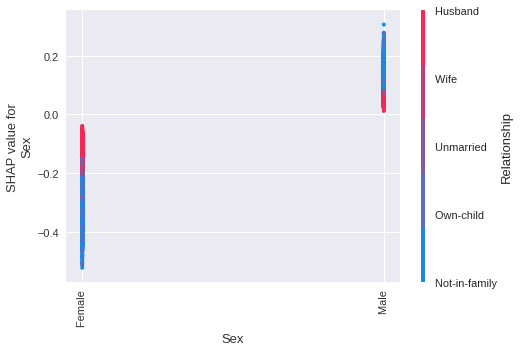

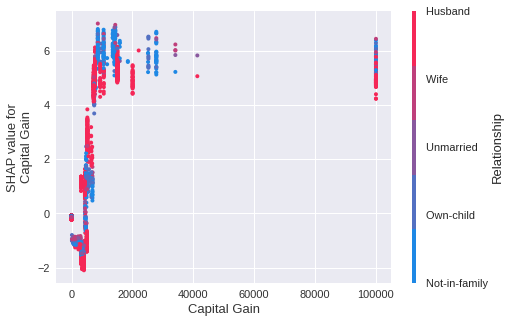

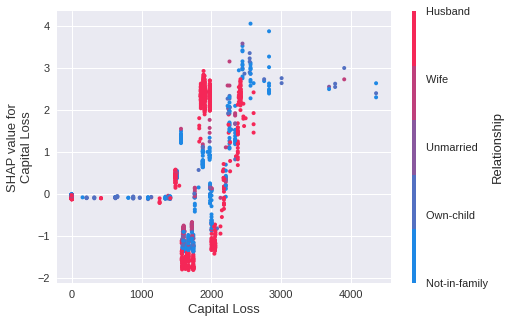

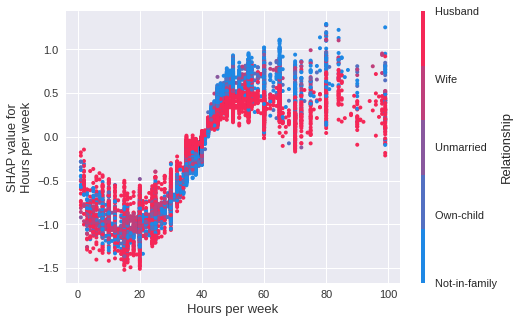

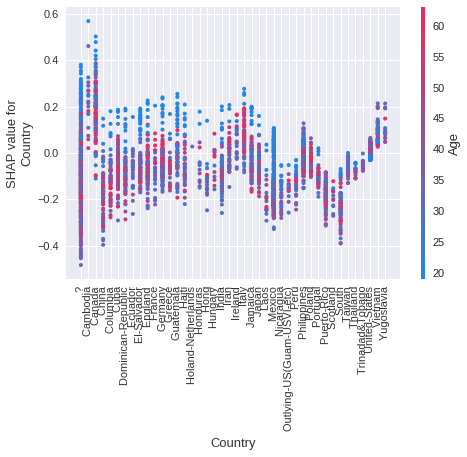

In [44]:
for name in X_train.columns :
    shap.dependence_plot(name, shap_values ,X ,display_features = X_display)

## 간단한 지도학습 클러스터링

In [0]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

shap_pca50 = PCA(n_components=12).fit_transform(shap_values[:1000,:-1])
shap_embedded = TSNE(n_components=2, perplexity=50).fit_transform(shap_values[:1000,:-1])

In [0]:
import matplotlib
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import MaxNLocator
cdict1 = {
    'red': ((0.0, 0.11764705882352941, 0.11764705882352941),
            (1.0, 0.9607843137254902, 0.9607843137254902)),

    'green': ((0.0, 0.5333333333333333, 0.5333333333333333),
              (1.0, 0.15294117647058825, 0.15294117647058825)),

    'blue': ((0.0, 0.8980392156862745, 0.8980392156862745),
             (1.0, 0.3411764705882353, 0.3411764705882353)),

    'alpha': ((0.0, 1, 1),
              (0.5, 1, 1),
              (1.0, 1, 1))
}  # #1E88E5 -> #ff0052
red_blue_solid = LinearSegmentedColormap('RedBlue', cdict1)

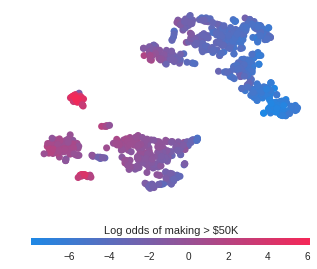

In [47]:
f = pl.figure(figsize=(5,5))
pl.scatter(shap_embedded[:,0],
           shap_embedded[:,1],
           c=shap_values[:1000,:].sum(1).astype(np.float64),
           linewidth=0, alpha=1., cmap=red_blue_solid)
cb = pl.colorbar(label="Log odds of making > $50K", aspect=40, orientation="horizontal")
cb.set_alpha(1)
cb.draw_all()
cb.outline.set_linewidth(0)
cb.ax.tick_params('x', length=0)
cb.ax.xaxis.set_label_position('top')
pl.gca().axis("off")
pl.show()

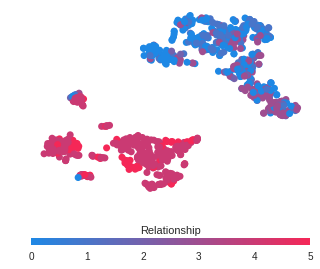

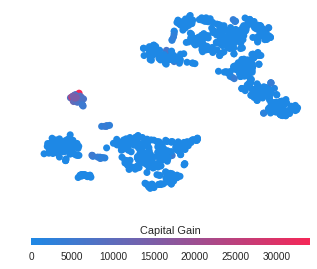

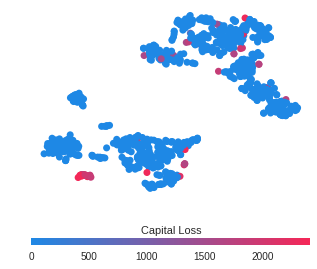

In [48]:
for feature in ["Relationship", "Capital Gain", "Capital Loss"]:
    f = pl.figure(figsize=(5,5))
    pl.scatter(shap_embedded[:,0],
               shap_embedded[:,1],
               c=X[feature].as_matrix()[:1000].astype(np.float64),
               linewidth=0, alpha=1., cmap=red_blue_solid)
    cb = pl.colorbar(label=feature, aspect=40, orientation="horizontal")
    cb.set_alpha(1)
    cb.draw_all()
    cb.outline.set_linewidth(0)
    cb.ax.tick_params('x', length=0)
    cb.ax.xaxis.set_label_position('top')
    pl.gca().axis("off")
    pl.show()

## 트리 당 오직 2개의 잎만 훈련시키고 변수들 간 작용이 없다고 하자
* Forcing the model to have no interaction terms means the effect of a feature on the outcome does not depend on the value of any other feature
* This is reflected in the SHAP dependence plots below as no vertical spread
* A vertical spread reflects that a single value of a feature can have different effects on the model output depending on the context of the other features present for an individual
*  However, for models without interaction terms, a feature always has the same impact regardless of what other attributes an individual may have.

* One the benefits of SHAP dependence plots over traditional partial dependence plots is this ability to distigush between between models with and without interaction terms
*  In other words, SHAP dependence plots give an idea of the magnitude of the interaction terms through the vertical variance of the scatter plot at a given feature value.

In [49]:
params = {
    "eta": 0.05,
    "max_depth": 1,
    "objective": "binary:logistic",
    "subsample": 0.5,
    "base_score": np.mean(y_train),
    "eval_metric": "logloss"
}
model_ind = xgboost.train(params, d_train, 5000, evals = [(d_test, "test")], verbose_eval=100, early_stopping_rounds=20)

[0]	test-logloss:0.541029
Will train until test-logloss hasn't improved in 20 rounds.
[100]	test-logloss:0.354907
[200]	test-logloss:0.328282
[300]	test-logloss:0.319084
[400]	test-logloss:0.313514
[500]	test-logloss:0.309417
[600]	test-logloss:0.306383
[700]	test-logloss:0.303762
[800]	test-logloss:0.302018
[900]	test-logloss:0.300485
[1000]	test-logloss:0.299173
[1100]	test-logloss:0.29813
[1200]	test-logloss:0.297276
[1300]	test-logloss:0.296257
[1400]	test-logloss:0.295407
[1500]	test-logloss:0.294782
[1600]	test-logloss:0.294123
[1700]	test-logloss:0.293489
[1800]	test-logloss:0.293013
[1900]	test-logloss:0.292561
[2000]	test-logloss:0.291921
[2100]	test-logloss:0.291609
Stopping. Best iteration:
[2130]	test-logloss:0.291378



In [0]:
shap_values_ind = shap.TreeExplainer(model_ind).shap_values(X)

/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:3184: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


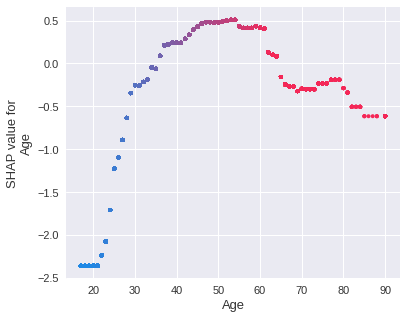

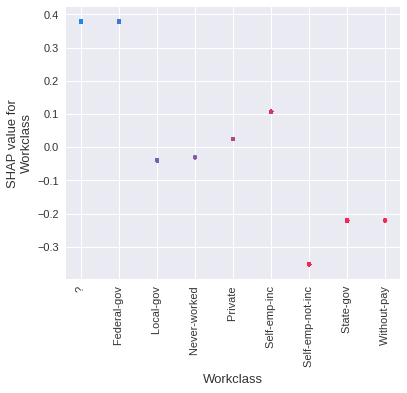

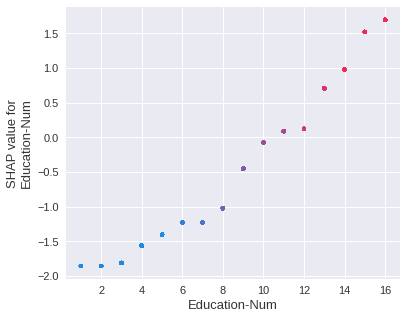

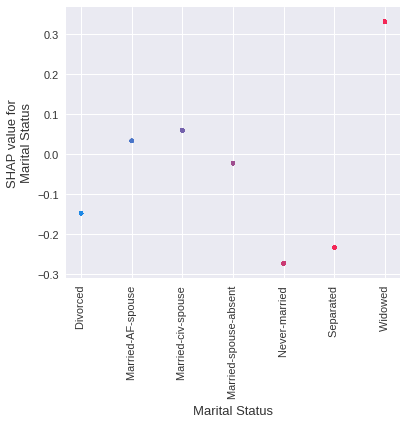

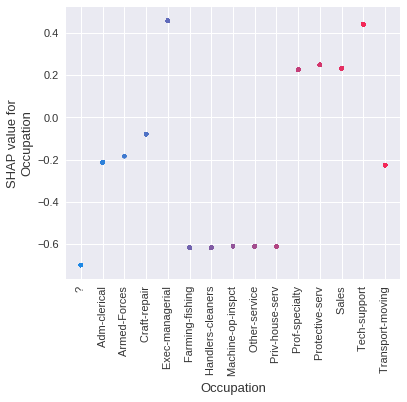

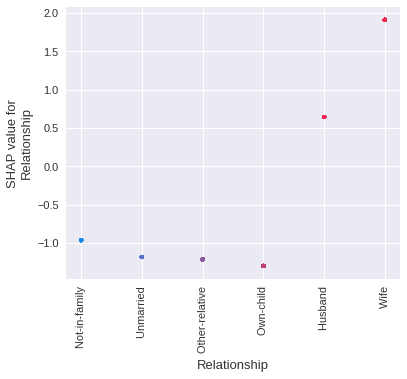

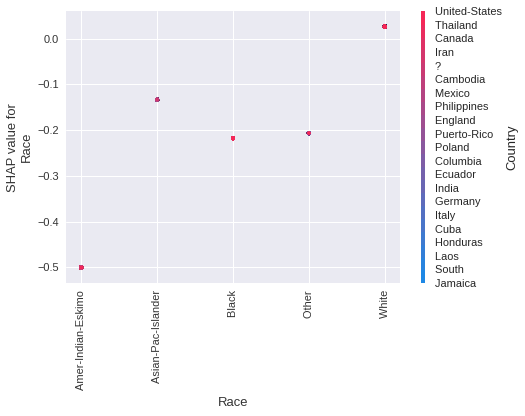

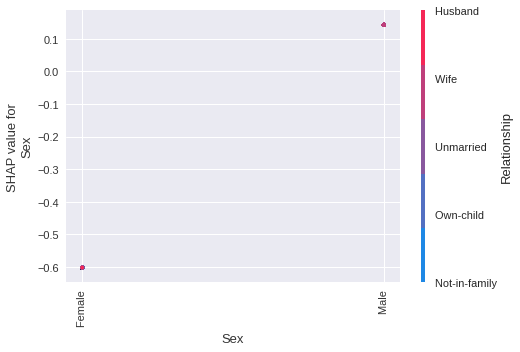

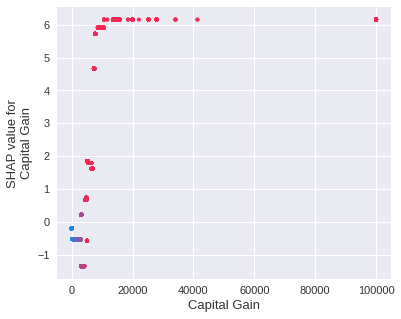

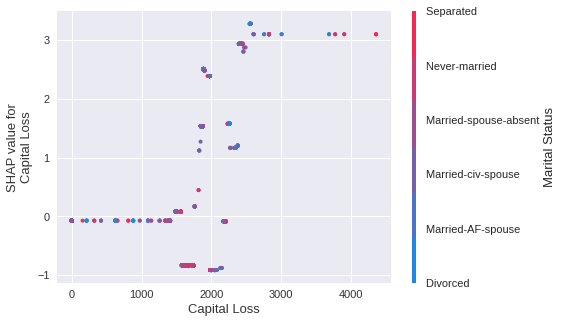

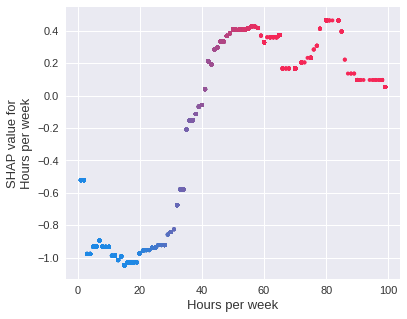

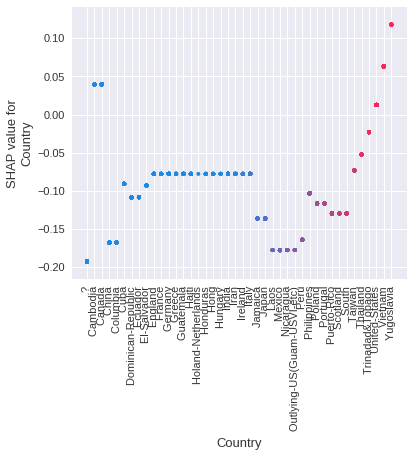

In [51]:
for name in X_train.columns:
    shap.dependence_plot(name, shap_values_ind, X, display_features=X_display)